## Training the Vision Transformer on a Custom Dataset

In this notebook, we are going to fine-tune a pre-trained Vision Transformer (which can be found from [Huggingface](https://github.com/huggingface/transformers)) on a Custom Dataset. For this notebook we will be using the Rock, Paper, Scissors dataset which can be found [here](https://public.roboflow.com/classification/rock-paper-scissors/1). This dataset is a collection of 2925 images images in 3 different classes. This tutorial is based on Huggingface's [Fine tuning the Vision Transformer on CIFAR 10 notebook](https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Fine_tuning_the_Vision_Transformer_on_CIFAR_10_with_the_%F0%9F%A4%97_Trainer.ipynb).

### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [How to Train the HuggingFace Vision Transformer On a Custom Dataset](blog.roboflow.com/how-to-train-the-huggingface-vision-transformer-on-a-custom-dataset/) concurrently.


We will prepare the data using [Roboflow's Preprocessing Tools](https://docs.roboflow.com/image-transformations/image-preprocessing), and train the model using this notebook. 

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train a Vision Transformer on your custom classification data.

To train our image classifier we take the following steps:

* Install Vision Transformer dependencies
* Download custom Image Classification data using Roboflow
* Use the Vision Transformer Feature Extractor
* Run the Vision Transformer training procedure
* Evaluate the Vision Transformer on a test image
* Export the Vision Transformer model for future inference


### **About**

[Roboflow](https://roboflow.com) enables teams to deploy custom computer vision models quickly and accurately. Convert data from to annotation format, assess dataset health, preprocess, augment, and more. It's free for your first 1000 source images.

**Looking for a vision model available via API without hassle? Try Roboflow Train.**

![Roboflow Wordmark](https://i.imgur.com/dcLNMhV.png)



Let's start by installing the relevant libraries.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers

Next, convert the folder structure dataset into a PyTorch dataset format using PyTorch's ImageFolder dataset structure:

In [2]:
import torchvision
from torchvision.transforms import ToTensor

train_ds = torchvision.datasets.ImageFolder('/home/sbaner24/Maize/Soybean_data/11-46_aug/data/train_res/', transform=ToTensor())
valid_ds = torchvision.datasets.ImageFolder('/home/sbaner24/Maize/Soybean_data/11-46_aug/test_inf_res/', transform=ToTensor())
test_ds = torchvision.datasets.ImageFolder('/home/sbaner24/Maize/Soybean_data/11-46_aug/data/test_res/', transform=ToTensor())

# Define the Model

Here we define the model.

The model itself uses a linear layer on top of a pre-trained `ViTModel`. We place a linear layer on top of the last hidden state of the [CLS] token, which serves as a good representation of an entire image. We also add dropout for regularization.

**Note:** The Vision Transformer pretrained model can be used as a regular PyTorch layer.

In [3]:
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=5):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch32-224-in21k',output_attentions=True)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)
        attn=outputs.attentions

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        if loss is not None:
          return logits, loss.item(),attn
        else:
          return logits, None,attn

/home/sbaner24/miniconda3/envs/venv_vit/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# Define the Model Parameters


EPOCHS = 50
BATCH_SIZE = 35
LEARNING_RATE = 1e-5

We will use the pretrained Vision Transformer feature extractor, an Adam Optimizer, and a Cross Entropy Loss function.

In [5]:
from transformers import ViTFeatureExtractor
import torch.nn as nn
import torch
# Define Model
model = ViTForImageClassification(len(train_ds.classes))    
# Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch32-224-in21k')
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()
# Use GPU if available  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
if torch.cuda.is_available():
    model.cuda() 

## Train the Model

In [6]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np

print("Number of train samples: ", len(train_ds))
print("Number of test samples: ", len(test_ds))
print("Detected Classes are: ", train_ds.class_to_idx) 

train_loader = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
test_loader  = data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) 

# Train the model
for epoch in range(EPOCHS):        
  for step, (x, y) in enumerate(train_loader):
    # Change input array into list with each batch being one element
    x = np.split(np.squeeze(np.array(x)), BATCH_SIZE)
    # Remove unecessary dimension
    for index, array in enumerate(x):
      x[index] = np.squeeze(array)
    # Apply feature extractor, stack back into 1 tensor and then convert to tensor
    x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))
    # Send to GPU if available
    x, y  = x.to(device), y.to(device)
    b_x = Variable(x)   # batch x (image)
    b_y = Variable(y)   # batch y (target)
    # Feed through model
    output, loss,atten = model(b_x, None)
    # Calculate loss
    if loss is None: 
      loss = loss_func(output, b_y)   
      optimizer.zero_grad()           
      loss.backward()                 
      optimizer.step()

    if step % 50 == 0:
      # Get the next batch for testing purposes
      test = next(iter(test_loader))
      test_x = test[0]
      # Reshape and get feature matrices as needed
      test_x = np.split(np.squeeze(np.array(test_x)), BATCH_SIZE)
      for index, array in enumerate(test_x):
        test_x[index] = np.squeeze(array)
      test_x = torch.tensor(np.stack(feature_extractor(test_x)['pixel_values'], axis=0))
      # Send to appropirate computing device
      test_x = test_x.to(device)
      test_y = test[1].to(device)
      # Get output (+ respective class) and compare to target
      test_output, loss,test_atten = model(test_x, test_y)
      test_output = test_output.argmax(1)
      # Calculate Accuracy
      accuracy = (test_output == test_y).sum().item() / BATCH_SIZE
      print('Epoch: ', epoch, '| train loss: %.4f' % loss, '| val accuracy: %.2f' % accuracy)

Number of train samples:  2590
Number of test samples:  288
Detected Classes are:  {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}
Epoch:  0 | train loss: 1.5640 | val accuracy: 0.29
Epoch:  0 | train loss: 1.3206 | val accuracy: 0.60
Epoch:  1 | train loss: 1.2265 | val accuracy: 0.63
Epoch:  1 | train loss: 1.0404 | val accuracy: 0.71
Epoch:  2 | train loss: 0.9392 | val accuracy: 0.71
Epoch:  2 | train loss: 0.8784 | val accuracy: 0.66
Epoch:  3 | train loss: 0.7218 | val accuracy: 0.77
Epoch:  3 | train loss: 0.6760 | val accuracy: 0.77
Epoch:  4 | train loss: 0.5176 | val accuracy: 0.91
Epoch:  4 | train loss: 0.6401 | val accuracy: 0.77
Epoch:  5 | train loss: 0.4922 | val accuracy: 0.83
Epoch:  5 | train loss: 0.4590 | val accuracy: 0.91
Epoch:  6 | train loss: 0.5247 | val accuracy: 0.86
Epoch:  6 | train loss: 0.2793 | val accuracy: 0.97
Epoch:  7 | train loss: 0.2816 | val accuracy: 0.94
Epoch:  7 | train loss: 0.3011 | val accuracy: 0.91
Epoch:  8 | train loss: 0.3238 | val accurac

In [7]:
torch.save(model, '/home/sbaner24/Maize/Soybean_data/Output/model.pt')

In [8]:
MODEL_PATH = '/home/sbaner24/Maize/Soybean_data/Output/model.pt'
model = ViTForImageClassification(len(train_ds.classes))    
model = torch.load(MODEL_PATH)
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

In [ ]:
#model.vit.encoder.layer[0].attention.forward

## Evaluate on a Test Image

Finally, let's evaluate the model on a test image:

torch.Size([1, 3, 224, 224])


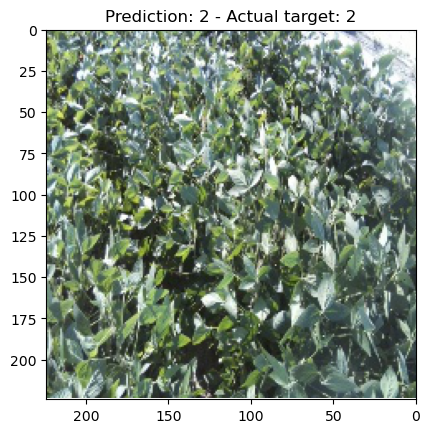

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import torchvision.transforms as T


transform = T.ToPILImage()

#valid_ds = torchvision.datasets.ImageFolder('/home/sbaner24/Maize/Atten_Deep_MIL/Data/Trial006/test_inf/y20m10d20/', transform=ToTensor())

EVAL_BATCH = 1
eval_loader  = data.DataLoader(valid_ds, batch_size=EVAL_BATCH, shuffle=True, num_workers=4) 
# Disable grad
with torch.no_grad():
    
  inputs, target = next(iter(eval_loader))
  # Reshape and get feature matrices as needed
  print(inputs.shape)
  input_att=torch.squeeze(inputs)
  im = transform(input_att)
  inputs = inputs[0].permute(1, 2, 0)
  # Save original Input
  originalInput = inputs
  for index, array in enumerate(inputs):
    inputs[index] = np.squeeze(array)
  inputs = torch.tensor(np.stack(feature_extractor(inputs)['pixel_values'], axis=0))

  # Send to appropriate computing device
  inputs = inputs.to(device)
  target = target.to(device)
 
  # Generate prediction
  prediction, loss,atten = model(inputs, target)
    
  # Predicted class value using argmax
  predicted_class = np.argmax(prediction.cpu())
  value_predicted = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(predicted_class)]
  value_target = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(target)]
        
  # Show result
  plt.imshow(originalInput)
  plt.xlim(224,0)
  plt.ylim(224,0)
  plt.title(f'Prediction: {value_predicted} - Actual target: {value_target}')
  plt.show()

In [10]:
#Code to generate attention maps
    
# Stack the individual attention matrices from individual Transformer blocks.
att_mat = torch.stack(atten).squeeze(1)
# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat.cpu() + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")

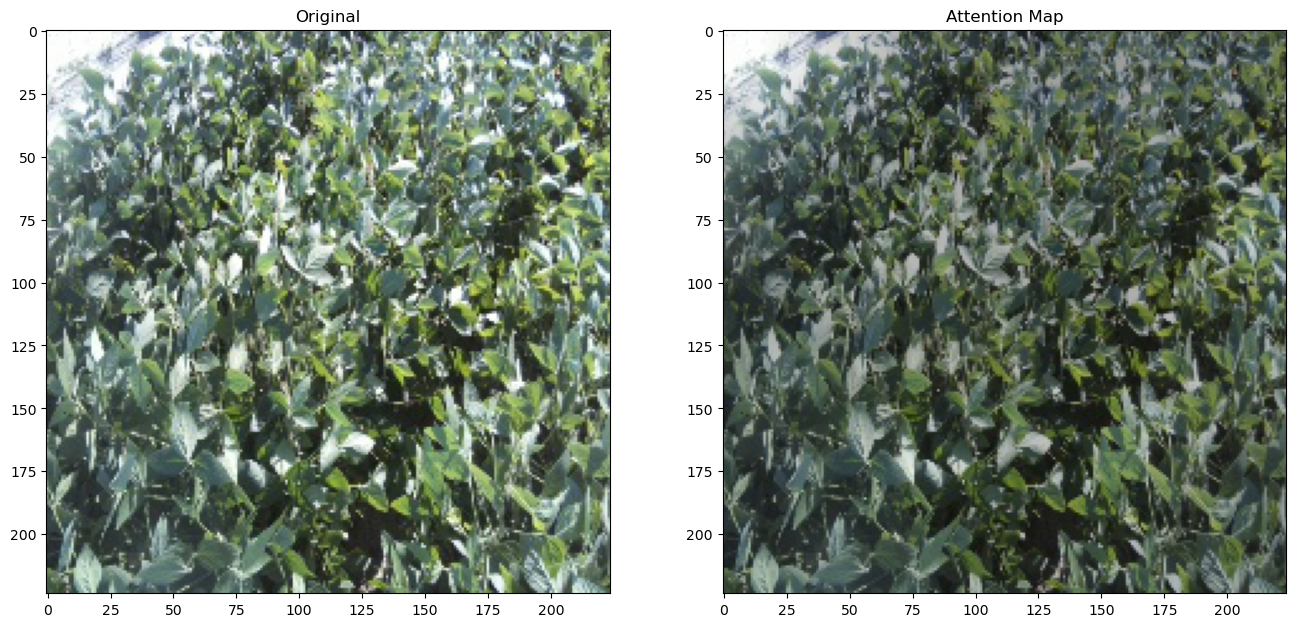

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(result)

In [13]:
predicted=[]
gt=[]

with torch.no_grad():
    for step, (x, y) in enumerate(eval_loader):
        inputs, target = next(iter(eval_loader))
        # Reshape and get feature matrices as needed
        print(inputs.shape)
        inputs = inputs[0].permute(1, 2, 0)
        # Save original Input
        originalInput = inputs
        for index, array in enumerate(inputs):
            inputs[index] = np.squeeze(array)
        inputs = torch.tensor(np.stack(feature_extractor(inputs)['pixel_values'], axis=0))

        # Send to appropriate computing device
        inputs = inputs.to(device)
        target = target.to(device)
 
        # Generate prediction
        prediction, loss,atten = model(inputs, target)
    
        # Predicted class value using argmax
        predicted_class = np.argmax(prediction.cpu())
        value_predicted = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(predicted_class)]
        value_target = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(target)]
        print("Predicted:"+str(value_predicted)+" Target: "+str(value_target))
        predicted.append(value_predicted)
        gt.append(value_target)

print("Gt Labels:", gt)
print("Predicted Labels:",predicted)

torch.Size([1, 3, 224, 224])
Predicted:1 Target: 1
torch.Size([1, 3, 224, 224])
Predicted:1 Target: 1
torch.Size([1, 3, 224, 224])
Predicted:1 Target: 1
torch.Size([1, 3, 224, 224])
Predicted:0 Target: 1
torch.Size([1, 3, 224, 224])
Predicted:3 Target: 0
torch.Size([1, 3, 224, 224])
Predicted:4 Target: 4
torch.Size([1, 3, 224, 224])
Predicted:4 Target: 4
torch.Size([1, 3, 224, 224])
Predicted:4 Target: 4
torch.Size([1, 3, 224, 224])
Predicted:4 Target: 4
torch.Size([1, 3, 224, 224])
Predicted:2 Target: 3
torch.Size([1, 3, 224, 224])
Predicted:1 Target: 1
torch.Size([1, 3, 224, 224])
Predicted:1 Target: 0
torch.Size([1, 3, 224, 224])
Predicted:4 Target: 4
torch.Size([1, 3, 224, 224])
Predicted:4 Target: 4
torch.Size([1, 3, 224, 224])
Predicted:4 Target: 4
torch.Size([1, 3, 224, 224])
Predicted:0 Target: 0
torch.Size([1, 3, 224, 224])
Predicted:3 Target: 3
torch.Size([1, 3, 224, 224])
Predicted:1 Target: 2
torch.Size([1, 3, 224, 224])
Predicted:1 Target: 1
torch.Size([1, 3, 224, 224])
Pr

torch.Size([1, 3, 224, 224])
Predicted:1 Target: 2
torch.Size([1, 3, 224, 224])
Predicted:0 Target: 0
torch.Size([1, 3, 224, 224])
Predicted:2 Target: 2
torch.Size([1, 3, 224, 224])
Predicted:1 Target: 1
torch.Size([1, 3, 224, 224])
Predicted:3 Target: 3
torch.Size([1, 3, 224, 224])
Predicted:4 Target: 4
torch.Size([1, 3, 224, 224])
Predicted:1 Target: 1
torch.Size([1, 3, 224, 224])
Predicted:1 Target: 2
torch.Size([1, 3, 224, 224])
Predicted:1 Target: 1
torch.Size([1, 3, 224, 224])
Predicted:4 Target: 2
torch.Size([1, 3, 224, 224])
Predicted:1 Target: 1
torch.Size([1, 3, 224, 224])
Predicted:4 Target: 4
torch.Size([1, 3, 224, 224])
Predicted:4 Target: 2
torch.Size([1, 3, 224, 224])
Predicted:1 Target: 1
torch.Size([1, 3, 224, 224])
Predicted:0 Target: 0
torch.Size([1, 3, 224, 224])
Predicted:2 Target: 3
torch.Size([1, 3, 224, 224])
Predicted:0 Target: 0
torch.Size([1, 3, 224, 224])
Predicted:0 Target: 0
torch.Size([1, 3, 224, 224])
Predicted:2 Target: 4
torch.Size([1, 3, 224, 224])
Pr

torch.Size([1, 3, 224, 224])
Predicted:1 Target: 1
torch.Size([1, 3, 224, 224])
Predicted:1 Target: 1
torch.Size([1, 3, 224, 224])
Predicted:1 Target: 1
torch.Size([1, 3, 224, 224])
Predicted:1 Target: 2
torch.Size([1, 3, 224, 224])
Predicted:1 Target: 1
torch.Size([1, 3, 224, 224])
Predicted:1 Target: 0
torch.Size([1, 3, 224, 224])
Predicted:2 Target: 2
torch.Size([1, 3, 224, 224])
Predicted:1 Target: 1
torch.Size([1, 3, 224, 224])
Predicted:3 Target: 3
torch.Size([1, 3, 224, 224])
Predicted:4 Target: 4
torch.Size([1, 3, 224, 224])
Predicted:4 Target: 4
torch.Size([1, 3, 224, 224])
Predicted:3 Target: 0
torch.Size([1, 3, 224, 224])
Predicted:1 Target: 2
torch.Size([1, 3, 224, 224])
Predicted:1 Target: 1
torch.Size([1, 3, 224, 224])
Predicted:3 Target: 3
torch.Size([1, 3, 224, 224])
Predicted:1 Target: 0
torch.Size([1, 3, 224, 224])
Predicted:1 Target: 2
torch.Size([1, 3, 224, 224])
Predicted:1 Target: 1
torch.Size([1, 3, 224, 224])
Predicted:1 Target: 3
Gt Labels: ['1', '1', '1', '1',

In [15]:
#pred_list=[0 if i=='Plant2' else 1 for i in predicted]
#gt_list=[0 if i=='Plant2' else 1 for i in gt]
pred_list= [eval(i) for i in predicted]
gt_list= [eval(i) for i in gt]

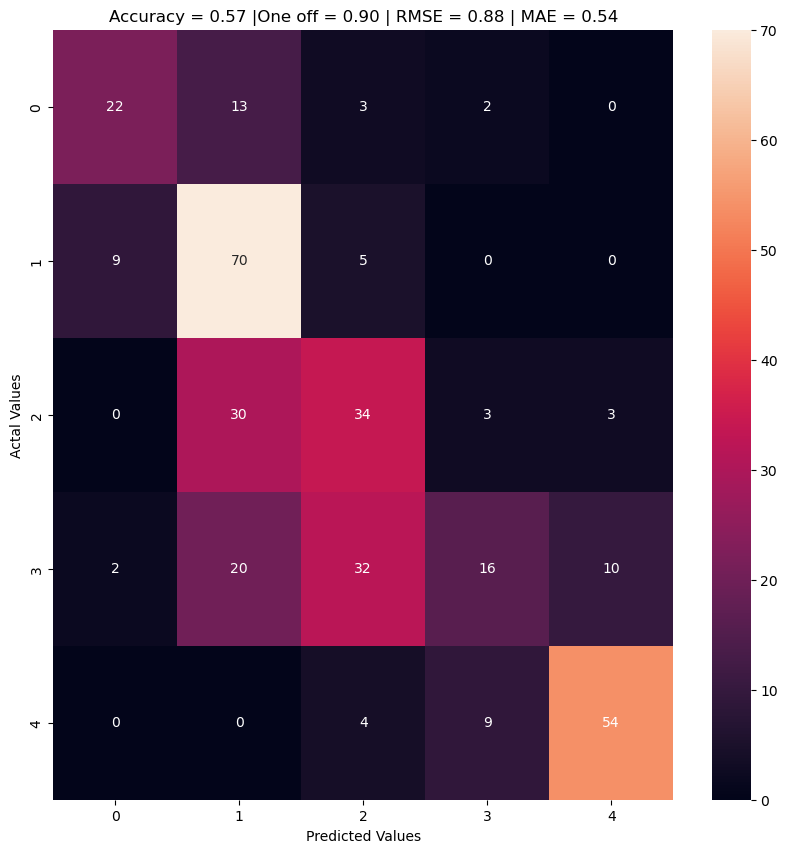

In [16]:
import os
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import matrix

dst='/home/sbaner24/Maize/Soybean_data/Output/'

cm = confusion_matrix(gt_list, pred_list)
cm_df = pd.DataFrame(cm,
                     index = ['0','1','2','3','4'], 
                     #index = ['0','1'], 
                     columns = ['0','1','2','3','4'])
                     #columns = ['0','1'])
#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
acc=np.mean(np.equal(pred_list, gt_list))
one_off=np.mean(np.greater_equal(np.asarray(pred_list),  np.asarray(gt_list) - 1) & np.less_equal(np.asarray(pred_list), np.asarray(gt_list) + 1))
rmse=np.sqrt(np.mean((np.asarray(pred_list)-np.asarray(gt_list))**2))
mae=np.mean(np.abs(np.asarray(pred_list)-np.asarray(gt_list)))
plt.title('Accuracy = {:4.2f} |One off = {:4.2f} | RMSE = {:4.2f} | MAE = {:4.2f}'.format(acc,one_off,rmse,mae))
#plt.title('Accuracy = {:4.2f} | RMSE = {:4.2f} | MAE = {:4.2f}'.format(acc,one_off,rmse,mae))
plt.savefig(dst+'cm_model_run6'+'.png')

In [ ]:
#Donot Run Cell
#Attention map different Approach
#Work in progress

import tensorflow as tf
PATCH_SIZE=16

def attention_heatmap(attention_score_dict, image):
    num_tokens = 2 
    # Sort the Transformer blocks in order of their depth.
    attention_score_list = list(attention_score_dict.keys())
    attention_score_list.sort(key=lambda x: int(x.split("_")[-2]), reverse=True)

    # Process the attention maps for overlay.
    w_featmap = image.size[1] // PATCH_SIZE
    h_featmap = image.size[0] // PATCH_SIZE
    attention_scores = attention_score_dict[attention_score_list[0]]
    attention_scores=atten
    print(attention_scores)
    # Taking the representations from CLS token.
    attentions = attention_scores[0, :, 0, num_tokens:].reshape(num_heads, -1)

    # Reshape the attention scores to resemble mini patches.
    attentions = attentions.reshape(num_heads, w_featmap, h_featmap)
    attentions = attentions.transpose((1, 2, 0))

    # Resize the attention patches to 224x224 (224: 14x16).
    attentions = tf.image.resize(
        attentions, size=(h_featmap * PATCH_SIZE, w_featmap * PATCH_SIZE)
    )
    return attentions

In [ ]:
#work in Progress
#Donot Run cell


#in1k_mean = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])
#in1k_std = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])

#preprocessed_img_orig = (input * in1k_std) + in1k_mean
#preprocessed_img_orig = preprocessed_img_orig / 255.0
#preprocessed_img_orig = tf.clip_by_value(preprocessed_img_orig, 0.0, 1.0).numpy()

# Generate the attention heatmaps.
attentions = attention_heatmap(atten, im)

# Plot the maps.
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 13))
img_count = 0

for i in range(3):
    for j in range(4):
        if img_count < len(attentions):
            axes[i, j].imshow(preprocessed_img_orig[0])
            axes[i, j].imshow(attentions[..., img_count], cmap="inferno", alpha=0.6)
            axes[i, j].title.set_text(f"Attention head: {img_count}")
            axes[i, j].axis("off")
            img_count += 1